# Import libraries

In [1]:
import tensorflow as tf

import sklearn
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.linear_model import Lasso, LinearRegression, Ridge, LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import scipy as sp
from scipy import stats

import pandas as pd

import seaborn as sns

import numpy as np

import matplotlib.pyplot as plt

import missingno as msno

import pickle

import os

# User-Defined Function

In [2]:
def categorical_matrix_display(df, columns):
    dim = len(columns)
    array = np.zeros((dim, dim))          

    for i, name1 in enumerate(columns):
        for j, name2 in enumerate(columns):
            logit = LogisticRegression()
            logit.fit(df[name1].values.reshape(-1, 1), df[name2])
            score = logit.score(df[name1].values.reshape(-1, 1), df[name2])
            array[i, j] = score

    arrayFrame = pd.DataFrame(data=array, columns=columns)
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    sns.heatmap(arrayFrame, annot=True, ax=ax, yticklabels=columns, vmin=0, vmax=1)


def cramers_V(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))


def cramersVMatrix(df, col):
    len_cat = len(col)
    array  = np.zeros((len_cat, len_cat))

    for i, name1 in enumerate(col):
        for j, name2 in enumerate(col):
            cross_tab = pd.crosstab(df[name1], df[name2]).to_numpy()
            value = cramers_V(cross_tab)
            array[i, j] = value

    array_frame = pd.DataFrame(data=array, columns=col)
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    sns.heatmap(array_frame, annot=True, ax=ax, yticklabels=col, vmin=0, vmax=1)

# Load data

In [3]:
path = os.path.join(os.getcwd(), 'data', 'cardio_train.csv')
df = pd.read_csv(path, delimiter = ';')
df 

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168.0,62.0,110,80,1.0,1,0,0.0,1,0
1,1,20228,1,156.0,85.0,140,90,3.0,1,0,0.0,1,1
2,2,18857,1,165.0,64.0,130,70,3.0,1,0,0.0,0,1
3,3,17623,2,169.0,82.0,150,100,1.0,1,0,0.0,1,1
4,4,17474,1,156.0,56.0,100,60,1.0,1,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69998,99993,19240,2,168.0,76.0,120,80,1.0,1,1,0.0,1,0
69999,99995,22601,1,158.0,126.0,140,90,2.0,2,0,0.0,1,1
70000,99996,19066,2,183.0,105.0,180,90,3.0,1,0,1.0,0,1
70001,99998,22431,1,163.0,72.0,135,80,1.0,2,0,0.0,0,1


- Age | Objective Feature | age | int (days)
- Height | Objective Feature | height | int (cm) |
- Weight | Objective Feature | weight | float (kg) |
- Gender | Objective Feature | gender | categorical code |
- Systolic blood pressure | Examination Feature | ap_hi | int |
- Diastolic blood pressure | Examination Feature | ap_lo | int |
- Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
- Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
- Smoking | Subjective Feature | smoke | binary |
- Alcohol intake | Subjective Feature | alco | binary |
- Physical activity | Subjective Feature | active | binary |
- Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

## drop 'id' column

In [4]:
df = df.drop('id', axis=1)
df

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168.0,62.0,110,80,1.0,1,0,0.0,1,0
1,20228,1,156.0,85.0,140,90,3.0,1,0,0.0,1,1
2,18857,1,165.0,64.0,130,70,3.0,1,0,0.0,0,1
3,17623,2,169.0,82.0,150,100,1.0,1,0,0.0,1,1
4,17474,1,156.0,56.0,100,60,1.0,1,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
69998,19240,2,168.0,76.0,120,80,1.0,1,1,0.0,1,0
69999,22601,1,158.0,126.0,140,90,2.0,2,0,0.0,1,1
70000,19066,2,183.0,105.0,180,90,3.0,1,0,1.0,0,1
70001,22431,1,163.0,72.0,135,80,1.0,2,0,0.0,0,1


# Rename columns

In [5]:
df = df.rename(columns = {'ap_hi': 'sys', 'ap_lo': 'dia'})
df

,age,gender,height,weight,sys,dia,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168.0,62.0,110,80,1.0,1,0,0.0,1,0
1,20228,1,156.0,85.0,140,90,3.0,1,0,0.0,1,1
2,18857,1,165.0,64.0,130,70,3.0,1,0,0.0,0,1
3,17623,2,169.0,82.0,150,100,1.0,1,0,0.0,1,1
4,17474,1,156.0,56.0,100,60,1.0,1,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
69998,19240,2,168.0,76.0,120,80,1.0,1,1,0.0,1,0
69999,22601,1,158.0,126.0,140,90,2.0,2,0,0.0,1,1
70000,19066,2,183.0,105.0,180,90,3.0,1,0,1.0,0,1
70001,22431,1,163.0,72.0,135,80,1.0,2,0,0.0,0,1


# Convert values in 'age' column from days to years

In [6]:
df['age'] = round(df['age']/365).astype(int)
df

,age,gender,height,weight,sys,dia,cholesterol,gluc,smoke,alco,active,cardio
0,50,2,168.0,62.0,110,80,1.0,1,0,0.0,1,0
1,55,1,156.0,85.0,140,90,3.0,1,0,0.0,1,1
2,52,1,165.0,64.0,130,70,3.0,1,0,0.0,0,1
3,48,2,169.0,82.0,150,100,1.0,1,0,0.0,1,1
4,48,1,156.0,56.0,100,60,1.0,1,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
69998,53,2,168.0,76.0,120,80,1.0,1,1,0.0,1,0
69999,62,1,158.0,126.0,140,90,2.0,2,0,0.0,1,1
70000,52,2,183.0,105.0,180,90,3.0,1,0,1.0,0,1
70001,61,1,163.0,72.0,135,80,1.0,2,0,0.0,0,1


# Get general infos

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70003 entries, 0 to 70002
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70003 non-null  int32  
 1   gender       70003 non-null  int64  
 2   height       70001 non-null  float64
 3   weight       70002 non-null  float64
 4   sys          70003 non-null  int64  
 5   dia          70003 non-null  int64  
 6   cholesterol  70001 non-null  float64
 7   gluc         70003 non-null  int64  
 8   smoke        70003 non-null  int64  
 9   alco         70002 non-null  float64
 10  active       70003 non-null  int64  
 11  cardio       70003 non-null  int64  
dtypes: float64(4), int32(1), int64(7)
memory usage: 6.1 MB


# Find out how many NAs in each column

In [8]:
df.isnull().sum()

age            0
gender         0
height         2
weight         1
sys            0
dia            0
cholesterol    2
gluc           0
smoke          0
alco           1
active         0
cardio         0
dtype: int64

# Display rows with the NAs

## 'height' column

In [9]:
df[df['height'].isna()]

,age,gender,height,weight,sys,dia,cholesterol,gluc,smoke,alco,active,cardio
11,52,2,NaN,60.0,120,80,1.0,1,0,0.0,1,0
38088,54,1,NaN,78.0,130,80,1.0,1,0,0.0,1,0


## 'weight' column

In [10]:
df[df['weight'].isna()]

,age,gender,height,weight,sys,dia,cholesterol,gluc,smoke,alco,active,cardio
21576,54,2,165.0,NaN,120,80,1.0,1,0,0.0,0,1


## 'cholesterol' column

In [11]:
df[df['cholesterol'].isna()]

,age,gender,height,weight,sys,dia,cholesterol,gluc,smoke,alco,active,cardio
16,58,1,170.0,75.0,130,70,NaN,1,0,0.0,0,0
37978,54,1,147.0,63.0,130,80,NaN,1,0,0.0,1,1


## 'alco' column

In [12]:
df[df['alco'].isna()]

,age,gender,height,weight,sys,dia,cholesterol,gluc,smoke,alco,active,cardio
37464,58,1,153.0,95.0,160,100,1.0,1,0,NaN,1,0


# Handling NAs

## fill NAs of numerical column with its median value

In [13]:
df[['height', 'weight']] = df[['height', 'weight']].fillna(df[['height', 'weight']].median())
df.isnull().sum()

age            0
gender         0
height         0
weight         0
sys            0
dia            0
cholesterol    2
gluc           0
smoke          0
alco           1
active         0
cardio         0
dtype: int64

## drop rows that have NAs in any of its categorical feature

In [14]:
df = df.dropna(axis=0, subset=['cholesterol', 'alco'])
df

,age,gender,height,weight,sys,dia,cholesterol,gluc,smoke,alco,active,cardio
0,50,2,168.0,62.0,110,80,1.0,1,0,0.0,1,0
1,55,1,156.0,85.0,140,90,3.0,1,0,0.0,1,1
2,52,1,165.0,64.0,130,70,3.0,1,0,0.0,0,1
3,48,2,169.0,82.0,150,100,1.0,1,0,0.0,1,1
4,48,1,156.0,56.0,100,60,1.0,1,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
69998,53,2,168.0,76.0,120,80,1.0,1,1,0.0,1,0
69999,62,1,158.0,126.0,140,90,2.0,2,0,0.0,1,1
70000,52,2,183.0,105.0,180,90,3.0,1,0,1.0,0,1
70001,61,1,163.0,72.0,135,80,1.0,2,0,0.0,0,1


# Handle duplicates

## check for how many duplicates

In [15]:
df.duplicated().sum()

3819

## show which rows are duplicated

In [16]:
df[df.duplicated()]

,age,gender,height,weight,sys,dia,cholesterol,gluc,smoke,alco,active,cardio
47,50,1,162.0,107.0,150,90,2.0,1,0,0.0,1,1
89,54,2,166.0,94.0,140,90,2.0,3,0,0.0,1,1
136,58,2,160.0,57.0,110,80,2.0,1,0,0.0,1,0
845,41,2,165.0,60.0,120,80,1.0,1,0,0.0,0,0
864,54,1,165.0,68.0,120,80,1.0,1,0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
69930,53,2,175.0,80.0,120,80,1.0,1,0,0.0,1,1
69954,42,1,158.0,55.0,110,70,1.0,1,0,0.0,1,0
69986,54,1,165.0,72.0,120,80,1.0,1,0,0.0,1,0
69989,50,2,180.0,78.0,120,80,1.0,1,0,0.0,1,0


## Drop duplicates

In [17]:
df = df.drop_duplicates()
df

,age,gender,height,weight,sys,dia,cholesterol,gluc,smoke,alco,active,cardio
0,50,2,168.0,62.0,110,80,1.0,1,0,0.0,1,0
1,55,1,156.0,85.0,140,90,3.0,1,0,0.0,1,1
2,52,1,165.0,64.0,130,70,3.0,1,0,0.0,0,1
3,48,2,169.0,82.0,150,100,1.0,1,0,0.0,1,1
4,48,1,156.0,56.0,100,60,1.0,1,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
69998,53,2,168.0,76.0,120,80,1.0,1,1,0.0,1,0
69999,62,1,158.0,126.0,140,90,2.0,2,0,0.0,1,1
70000,52,2,183.0,105.0,180,90,3.0,1,0,1.0,0,1
70001,61,1,163.0,72.0,135,80,1.0,2,0,0.0,0,1


# Summary statistics

In [18]:
df.describe()

,age,height,weight,sys,dia
count,66181.000000,66181.000000,66181.000000,66181.000000,66181.000000
mean,53.365059,164.345341,74.578690,129.304453,97.607833
std,6.807816,8.353582,14.613249,158.371723,193.786882
min,30.000000,55.000000,10.000000,-150.000000,-70.000000
25%,48.000000,159.000000,65.000000,120.000000,80.000000
50%,54.000000,165.000000,72.000000,120.000000,80.000000
75%,59.000000,170.000000,83.000000,140.000000,90.000000
max,65.000000,250.000000,200.000000,16020.000000,11000.000000


# Outliers Handling (numerical variables)

## Get general view of outliers for each numerical feature

age          AxesSubplot(0.125,0.536818;0.227941x0.343182)
height    AxesSubplot(0.398529,0.536818;0.227941x0.343182)
weight    AxesSubplot(0.672059,0.536818;0.227941x0.343182)
sys             AxesSubplot(0.125,0.125;0.227941x0.343182)
dia          AxesSubplot(0.398529,0.125;0.227941x0.343182)
dtype: object

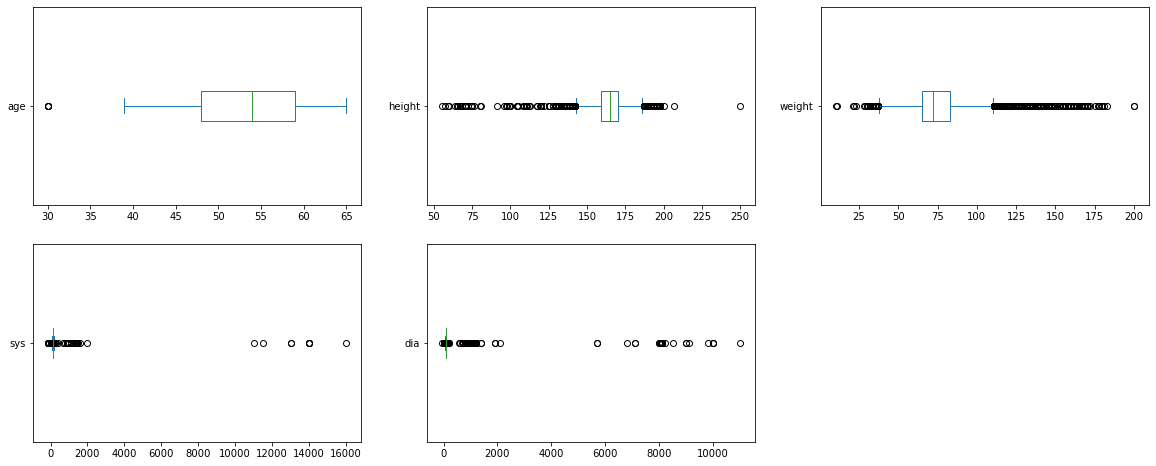

In [19]:
df[['age', 'height', 'weight', 'sys', 'dia']].plot.box(subplots=True, 
                                                       layout=(2, 3), 
                                                       figsize=(20, 8), 
                                                       vert=False, 
                                                       sharex=False)

## Defining InterQuartile Range (IQR), lower bounds, and upper bounds of each feature

In [20]:
# IQRs
iqrAge = np.quantile(df['age'], 0.75) - np.quantile(df['age'], 0.25)
iqrHeight = np.quantile(df['height'], 0.75) - np.quantile(df['height'], 0.25)
iqrWeight = np.quantile(df['weight'], 0.75) - np.quantile(df['weight'], 0.25)
iqrSys = np.quantile(df['sys'], 0.75) - np.quantile(df['sys'], 0.25)
iqrDia = np.quantile(df['dia'], 0.75) - np.quantile(df['dia'], 0.25)

#---------------------------------------------------------------------------
# Upper and lower bounds for each feature
lowerAge = np.quantile(df['age'], 0.25) - 1.5*iqrAge

lowerHeight = np.quantile(df['height'], 0.25) - 1.5*iqrHeight
upperHeight = np.quantile(df['height'], 0.75) + 1.5*iqrHeight

lowerWeight = np.quantile(df['weight'], 0.25) - 1.5*iqrWeight
upperWeight = np.quantile(df['weight'], 0.75) + 1.5*iqrWeight

lowerSys = np.quantile(df['sys'], 0.25) - 1.5*iqrSys
upperSys = np.quantile(df['sys'], 0.75) + 1.5*iqrSys

lowerDia = np.quantile(df['dia'], 0.25) - 1.5*iqrDia
upperDia = np.quantile(df['dia'], 0.75) + 1.5*iqrDia

## filter out all outliers in each feature

In [21]:
columns = ('age', 'height', 'weight', 'sys', 'dia')

ageValue = (lowerAge, 0)
heightValue = (lowerHeight, upperHeight)
weightValue = (lowerWeight, upperWeight)
sysValue = (lowerSys, upperSys)
diaValue = (lowerDia, upperDia)

values = (ageValue, heightValue, weightValue, sysValue, diaValue)

for col, value in zip(columns, values):
    if col == 'age':
        df = df.loc[df[col]>=value[0]]
    else:
        df = df.loc[(df[col]>=value[0]) & (df[col]<=value[1])]

df

,age,gender,height,weight,sys,dia,cholesterol,gluc,smoke,alco,active,cardio
0,50,2,168.0,62.0,110,80,1.0,1,0,0.0,1,0
1,55,1,156.0,85.0,140,90,3.0,1,0,0.0,1,1
2,52,1,165.0,64.0,130,70,3.0,1,0,0.0,0,1
3,48,2,169.0,82.0,150,100,1.0,1,0,0.0,1,1
5,60,1,151.0,67.0,120,80,2.0,2,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
69996,54,1,172.0,70.0,130,90,1.0,1,0,0.0,1,1
69997,58,1,165.0,80.0,150,80,1.0,1,0,0.0,1,1
69998,53,2,168.0,76.0,120,80,1.0,1,1,0.0,1,0
70001,61,1,163.0,72.0,135,80,1.0,2,0,0.0,0,1


# Correlation heat map between numerical features

<AxesSubplot:>

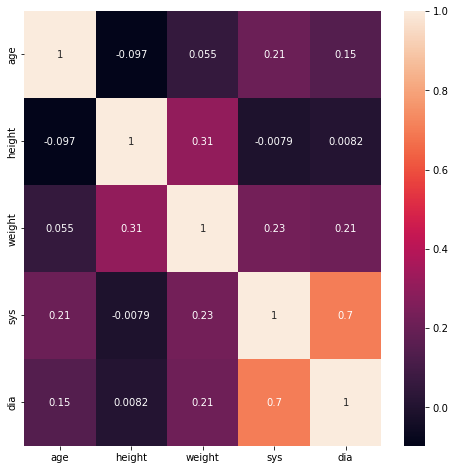

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.heatmap(df[['age', 'height', 'weight', 'sys', 'dia']].corr(), ax=ax, annot=True)

# Visualing distribution of categorical features

## Gender

[Text(0, 0, '38015 (64%)'), Text(0, 0, '21152 (36%)')]

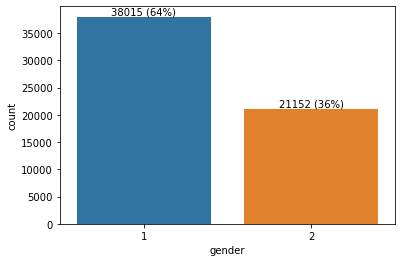

In [23]:
ax = sns.countplot(x=df['gender'], 
                   order=df['gender'].value_counts(ascending=False).index)
        
abs_values = df['gender'].value_counts(ascending=False)
rel_values = df['gender'].value_counts(ascending=False, normalize=True).values*100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)

## Cholesterol

[Text(0, 0, '43753 (74%)'), Text(0, 0, '8272 (14%)'), Text(0, 0, '7142 (12%)')]

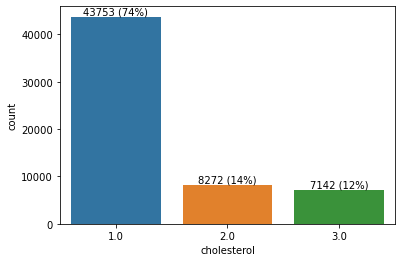

In [24]:
ax = sns.countplot(x=df['cholesterol'], 
                   order=df['cholesterol'].value_counts(ascending=False).index)
        
abs_values = df['cholesterol'].value_counts(ascending=False)
rel_values = df['cholesterol'].value_counts(ascending=False, normalize = True).values*100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)

## Glucose

[Text(0, 0, '49980 (84%)'), Text(0, 0, '4720 (8%)'), Text(0, 0, '4467 (8%)')]

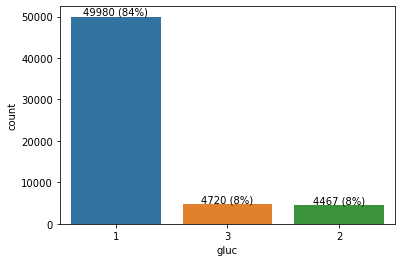

In [25]:
ax = sns.countplot(x=df['gluc'], 
                   order=df['gluc'].value_counts(ascending=False).index)
        
abs_values = df['gluc'].value_counts(ascending=False)
rel_values = df['gluc'].value_counts(ascending=False, normalize=True).values*100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)

## Smoke

[Text(0, 0, '53740 (91%)'), Text(0, 0, '5427 (9%)')]

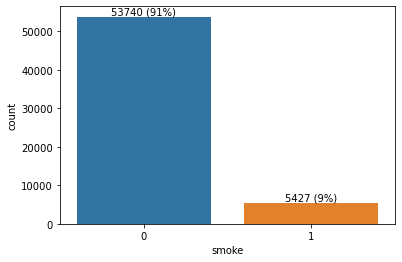

In [26]:
ax = sns.countplot(x=df['smoke'], 
                   order=df['smoke'].value_counts(ascending=False).index)
        
abs_values = df['smoke'].value_counts(ascending=False)
rel_values = df['smoke'].value_counts(ascending=False, normalize=True).values*100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)	

## Alcohol

[Text(0, 0, '55875 (94%)'), Text(0, 0, '3292 (6%)')]

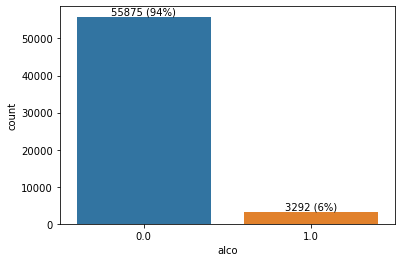

In [27]:
ax = sns.countplot(x=df['alco'], 
                   order=df['alco'].value_counts(ascending=False).index)
        
abs_values = df['alco'].value_counts(ascending=False)
rel_values = df['alco'].value_counts(ascending=False, normalize=True).values*100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)		

## Active

[Text(0, 0, '47181 (80%)'), Text(0, 0, '11986 (20%)')]

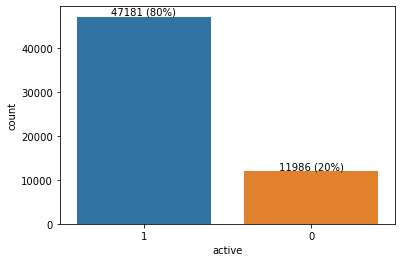

In [27]:
ax = sns.countplot(x=df['active'], 
                   order=df['active'].value_counts(ascending=False).index)
        
abs_values = df['active'].value_counts(ascending=False)
rel_values = df['active'].value_counts(ascending=False, normalize=True).values*100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)	

## Cardio

[Text(0, 0, '30183 (51%)'), Text(0, 0, '28984 (49%)')]

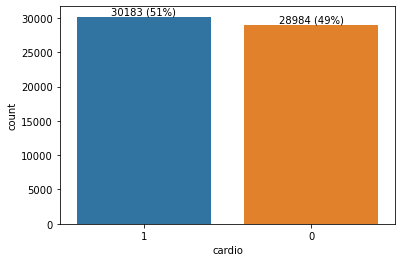

In [28]:
ax = sns.countplot(x=df['cardio'], 
                   order=df['cardio'].value_counts(ascending=False).index)
        
abs_values = df['cardio'].value_counts(ascending=False)
rel_values = df['cardio'].value_counts(ascending=False, normalize=True).values*100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls) 	

Because the categories of the target are approximately balanced, no need to filter by target anymore.

## Categorical features correlation (Using logistic regression)

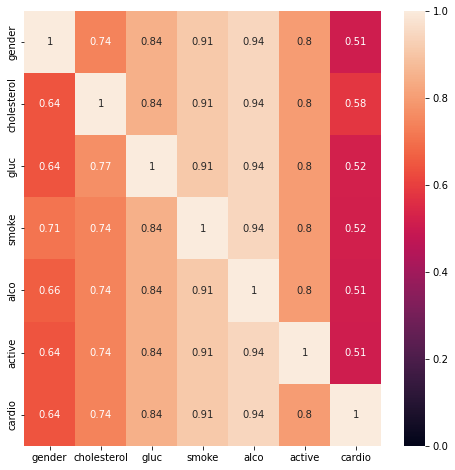

In [29]:
cat_columns = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']
categorical_matrix_display(df, cat_columns)

## Categorical features correlation (Using Cramer's V)

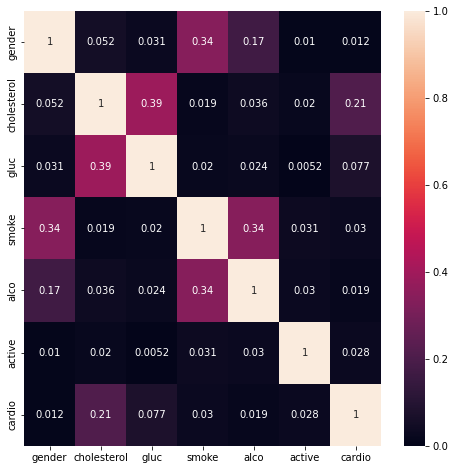

In [30]:
cat_columns = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']
cramersVMatrix(df, cat_columns)

# (Optional | Code are commented out | For owner's reference) Sample are sampled for each categorical features such that all the countplots above have balanced categories
## Will HEAVILY reduce the sample size

In [204]:
# groupbyGender = df.groupby('gender')
# df = groupbyGender.sample(20000, random_state = 42)
# df

In [205]:
# groupbyCholesterol = df.groupby('cholesterol')
# df = groupbyCholesterol.sample(4393, random_state = 42)
# df

In [206]:
# groupbyGluc = df.groupby('gluc')
# df = groupbyGluc.sample(1536, random_state = 42)
# df

In [207]:
# groupbySmoke = df.groupby('smoke')
# df = groupbySmoke.sample(572, random_state = 42)
# df

In [208]:
# groupbyAlco = df.groupby('alco')
# df = groupbyAlco.sample(201, random_state = 42)
# df

In [209]:
# groupbyActive = df.groupby('active')
# df = groupbyActive.sample(80, random_state = 42)
# df

In [210]:
# groupbyCardio = df.groupby('cardio')
# df = groupbyCardio.sample(66, random_state = 42)
# df

# Separating features from target

In [31]:
X = df.drop('cardio', axis=1)
X

,age,gender,height,weight,sys,dia,cholesterol,gluc,smoke,alco,active
0,50,2,168.0,62.0,110,80,1.0,1,0,0.0,1
1,55,1,156.0,85.0,140,90,3.0,1,0,0.0,1
2,52,1,165.0,64.0,130,70,3.0,1,0,0.0,0
3,48,2,169.0,82.0,150,100,1.0,1,0,0.0,1
5,60,1,151.0,67.0,120,80,2.0,2,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
69996,54,1,172.0,70.0,130,90,1.0,1,0,0.0,1
69997,58,1,165.0,80.0,150,80,1.0,1,0,0.0,1
69998,53,2,168.0,76.0,120,80,1.0,1,1,0.0,1
70001,61,1,163.0,72.0,135,80,1.0,2,0,0.0,0


In [32]:
y = df['cardio']
y

0        0
1        1
2        1
3        1
5        0
        ..
69996    1
69997    1
69998    0
70001    1
70002    0
Name: cardio, Length: 59167, dtype: int64

# train-test splitting

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# training 3 different classifier with the same scaler (standard scaler)

Logistic Regression
0.7199031040504761
              precision    recall  f1-score   support

           0       0.69      0.77      0.73      8612
           1       0.75      0.68      0.71      9139

    accuracy                           0.72     17751
   macro avg       0.72      0.72      0.72     17751
weighted avg       0.72      0.72      0.72     17751

-----------------------------------------
Decision Tree
0.6114585093797532
              precision    recall  f1-score   support

           0       0.60      0.61      0.60      8612
           1       0.62      0.61      0.62      9139

    accuracy                           0.61     17751
   macro avg       0.61      0.61      0.61     17751
weighted avg       0.61      0.61      0.61     17751

-----------------------------------------
Random Forest
0.6827784350177455
              precision    recall  f1-score   support

           0       0.67      0.68      0.68      8612
           1       0.70      0.68      0.69     

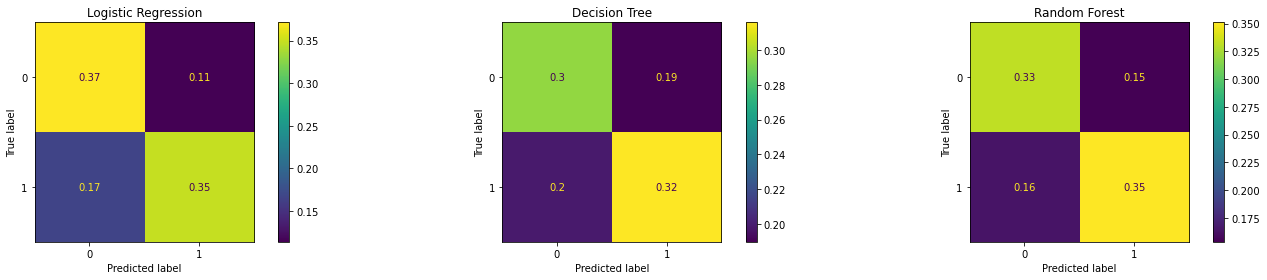

Best model is Logistic Regression with accuracy score: 0.7199031040504761


In [35]:
# pipes
logreg_cv_steps = [('scaler', StandardScaler()), 
                   ('logreg', LogisticRegression(random_state=42))]
logreg_cv_pipe = Pipeline(steps=logreg_cv_steps)

dt_cv_steps = [('scaler', StandardScaler()), 
               ('dt', DecisionTreeClassifier(random_state = 42))]
dt_cv_pipe = Pipeline(steps=dt_cv_steps)

rf_cv_steps = [('scaler', StandardScaler()), 
               ('rf', RandomForestClassifier(random_state=42))]
rf_cv_pipe = Pipeline(steps=rf_cv_steps)

# dict of different pipes
pipes = {'Logistic Regression': logreg_cv_pipe,
         'Decision Tree': dt_cv_pipe,
         'Random Forest': rf_cv_pipe}

best_score = 0.0

fig, ax = plt.subplots(1, 3, figsize=(20, 4))

for index, (name, pipe) in enumerate(pipes.items()):
    pipe.fit(X_train, y_train)
    ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test, normalize='all', ax=ax[index])
    ax[index].set_title(f'{name}')
    acc_score = pipe.score(X_test, y_test)
    class_report = classification_report(y_test, pipe.predict(X_test))
    if acc_score > best_score:
        best_score = acc_score
        best_pipe = pipe
        best_name = name
    print(name)
    print(acc_score)
    print(class_report)
    print('-----------------------------------------')

    if index == 2:
        plt.tight_layout() 
        plt.show()

print(f'Best model is {best_name} with accuracy score: {best_score}')

c:\Users\rhmnnmhmd\.conda\envs\tf_env\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\rhmnnmhmd\.conda\envs\tf_env\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\rhmnnmhmd\.conda\envs\tf_env\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\rhmnnmhmd\.conda\envs\tf_env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
  

Logistic Regression
0.7199031040504761
              precision    recall  f1-score   support

           0       0.69      0.77      0.73      8612
           1       0.75      0.68      0.71      9139

    accuracy                           0.72     17751
   macro avg       0.72      0.72      0.72     17751
weighted avg       0.72      0.72      0.72     17751

-----------------------------------------
Decision Tree
0.7228888513323193
              precision    recall  f1-score   support

           0       0.70      0.76      0.73      8612
           1       0.75      0.69      0.72      9139

    accuracy                           0.72     17751
   macro avg       0.72      0.72      0.72     17751
weighted avg       0.73      0.72      0.72     17751

-----------------------------------------
Random Forest
0.6827784350177455
              precision    recall  f1-score   support

           0       0.67      0.68      0.68      8612
           1       0.70      0.68      0.69     

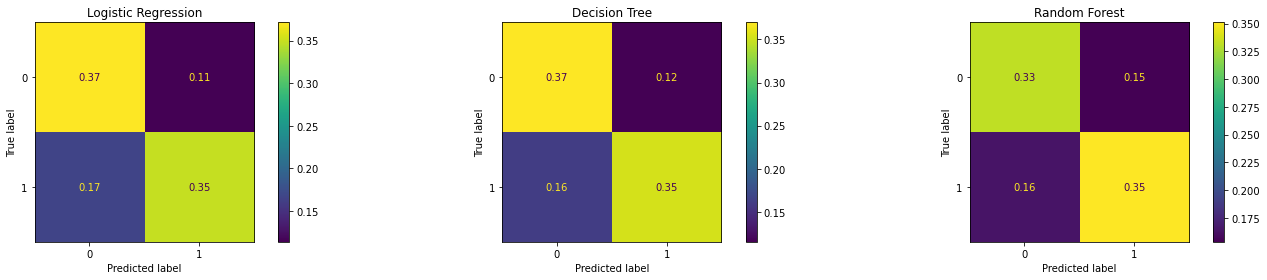

Best model is Decision Tree with accuracy score: 0.7228888513323193


In [36]:
# pipes
logreg_cv_steps = [('scaler', StandardScaler()), 
                   ('logreg', LogisticRegression(random_state=42))]
logreg_cv_pipe = Pipeline(steps=logreg_cv_steps)

dt_cv_steps = [('scaler', StandardScaler()), 
               ('dt', DecisionTreeClassifier(random_state = 42))]
dt_cv_pipe = Pipeline(steps=dt_cv_steps)

rf_cv_steps = [('scaler', StandardScaler()), 
               ('rf', RandomForestClassifier(random_state=42))]
rf_cv_pipe = Pipeline(steps=rf_cv_steps)

# parameters grid
params1 = {'logreg__penalty': ['l2', 'l1', 'elasticnet'],
          'logreg__C': [0.1, 1.0, 10]}

params2 = {'dt__min_samples_leaf': [1, 10, 100], 
          'dt__min_samples_split': [2, 20, 200]}

params3 = {'rf__n_estimators': [10, 100, 500],
          'rf__min_samples_split': [2, 20, 200]}

# dict of different pipes
pipes = {'Logistic Regression': logreg_cv_pipe,
         'Decision Tree': dt_cv_pipe,
         'Random Forest': rf_cv_pipe}

kf = KFold(n_splits=10, shuffle=True, random_state=42)

best_score = 0.0

fig, ax = plt.subplots(1, 3, figsize=(20, 4))

for index, (name, pipe) in enumerate(pipes.items()):

    if name == 'Logistic Regression':
        gridSearchCV = GridSearchCV(estimator=pipe, param_grid=params1, cv=kf, scoring='accuracy')
        gridSearchCV.fit(X_train, y_train)
        ConfusionMatrixDisplay.from_estimator(gridSearchCV, X_test, y_test, normalize='all', ax=ax[index])
        ax[index].set_title(f'{name}')
        acc_score = gridSearchCV.score(X_test, y_test)
        class_report = classification_report(y_test, gridSearchCV.predict(X_test))
       
        if acc_score > best_score:
            best_score = acc_score
            best_pipe = gridSearchCV
            best_name = name

        print(name)
        print(acc_score)
        print(class_report)
        
        print('-----------------------------------------')

    elif name == 'Decision Tree':
        gridSearchCV = GridSearchCV(estimator=pipe, param_grid=params2, cv=kf, scoring='accuracy')
        gridSearchCV.fit(X_train, y_train)
        ConfusionMatrixDisplay.from_estimator(gridSearchCV, X_test, y_test, normalize='all', ax=ax[index])
        ax[index].set_title(f'{name}')
        acc_score = gridSearchCV.score(X_test, y_test)
        class_report = classification_report(y_test, gridSearchCV.predict(X_test))

        if acc_score > best_score:
            best_score = acc_score
            best_pipe = pipe
            best_name = name

        print(name)
        print(acc_score)
        print(class_report)
        
        print('-----------------------------------------')

    elif name == 'Random Forest':
        model = pipe
        model.fit(X_train, y_train)
        ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, normalize='all', ax=ax[index])
        ax[index].set_title(f'{name}')
        acc_score = model.score(X_test, y_test)
        class_report = classification_report(y_test, model.predict(X_test))

        if acc_score > best_score:
            best_score = acc_score
            best_pipe = pipe
            best_name = name

        print(name)
        print(acc_score)
        print(class_report)
        
        plt.tight_layout() 
        plt.show()

    else:
        print('ERROR!!!')

print(f'Best model is {best_name} with accuracy score: {best_score}')

# Saving/Pickling the trained model

In [44]:
# saving
MODEL_PATH = os.path.join(os.getcwd(), 'model', 'model.pkl')
with open(MODEL_PATH, 'wb') as file:
    pickle.dump(best_pipe, file)

# loading
with open(MODEL_PATH, 'rb') as file:
    loaded_model = pickle.load(file)